<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Session5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem with resnet18 for GradCAM

* after 2nd block the channel size has become 4x4 and after block3 it's just 2x2.
* looks like a decent size channel output is required to create good gradcam image.

**To avoid this I have used stage/block2 output so we can get a decent size activations maps**

# Imports and Preprocessing

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input, Lambda, SpatialDropout2D
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras import regularizers
from keras.utils import np_utils
import keras
from keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


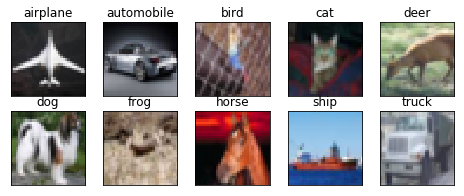

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Mount google drive

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Pretrainined resnet18 Shamelessly taken from: https://github.com/qubvel/classification_models

In [0]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-smin8sfu
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-smin8sfu
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1u2qzb4/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
from classification_models.resnet import ResNet18, preprocess_input

# prepare your data
n_classes = 10

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

W0701 22:51:39.533482 140443306850176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 22:51:39.577986 140443306850176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 22:51:39.579037 140443306850176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 22:51:39.581266 140443306850176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 22:51:39.585100 140443

44924928/44920640 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
____________________________________________

## Retraining for 10 more epochs on the cifar10 data

W0701 22:51:47.284040 140443306850176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
W0701 22:51:47.420071 140443306850176 deprecation.py:323] From

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 32s 83ms/step - loss: 0.8933 - acc: 0.6965 - val_loss: 0.9732 - val_acc: 0.6955
Epoch 2/10
390/390 [==============================] - 25s 64ms/step - loss: 0.6187 - acc: 0.7866 - val_loss: 0.7299 - val_acc: 0.7603
Epoch 3/10
390/390 [==============================] - 25s 63ms/step - loss: 0.5337 - acc: 0.8155 - val_loss: 0.6732 - val_acc: 0.7779
Epoch 4/10
390/390 [==============================] - 25s 63ms/step - loss: 0.4789 - acc: 0.8354 - val_loss: 0.5729 - val_acc: 0.8009
Epoch 5/10
390/390 [==============================] - 25s 63ms/step - loss: 0.4374 - acc: 0.8479 - val_loss: 0.5655 - val_acc: 0.8087
Epoch 6/10
390/390 [==============================] - 25s 64ms/step - loss: 0.3948 - acc: 0.8641 - val_loss: 0.6269 - val_acc: 0.7960
Epoch 7/10
390/390 [==============================] - 25s 64ms/step - loss: 0.3818 - acc: 0.8679 - val_loss: 0.5381 - val_acc: 0.8227
Epoch 8/10
390/390 [==============================] - 25s 63ms/step - los

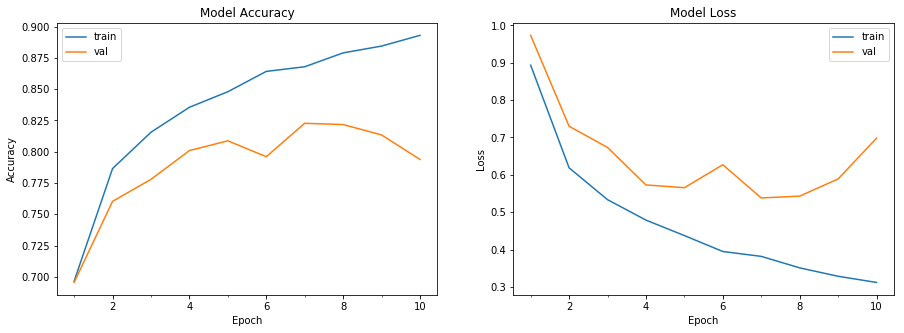

Accuracy on test data is: 79.38


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels),
#                                  callbacks=[lr_scheduler],
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
# save model
model.save('/content/gdrive/My Drive/EIP3/Session5/res18_oncifar.h5')

from keras.models import load_model
# load model back
# model = load_model('/content/gdrive/My Drive/EIP3/Session5/res18_oncifar.h5')

## Gradcam on misclassified test predictions

In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [0]:
def whatchyalookingat(j):
  img = test_features[j]
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("stage2_unit2_conv2")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(last_conv_layer.output_shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
#   img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255 * img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img*255, 0.6, heatmap, 0.4, 0)

  concatimg = cv2.hconcat([img,superimposed_img])
  
  return(concatimg)

In [0]:
#Predicting on test data
predict = model.predict(test_features)

In [0]:
#getting misclassified images
true_class = np.argmax(test_labels, axis = -1)
pred_classes = np.argmax(predict, axis = -1)
misclassified = [(i,x) for i, x in enumerate(pred_classes) if pred_classes[i]!=true_class[i]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


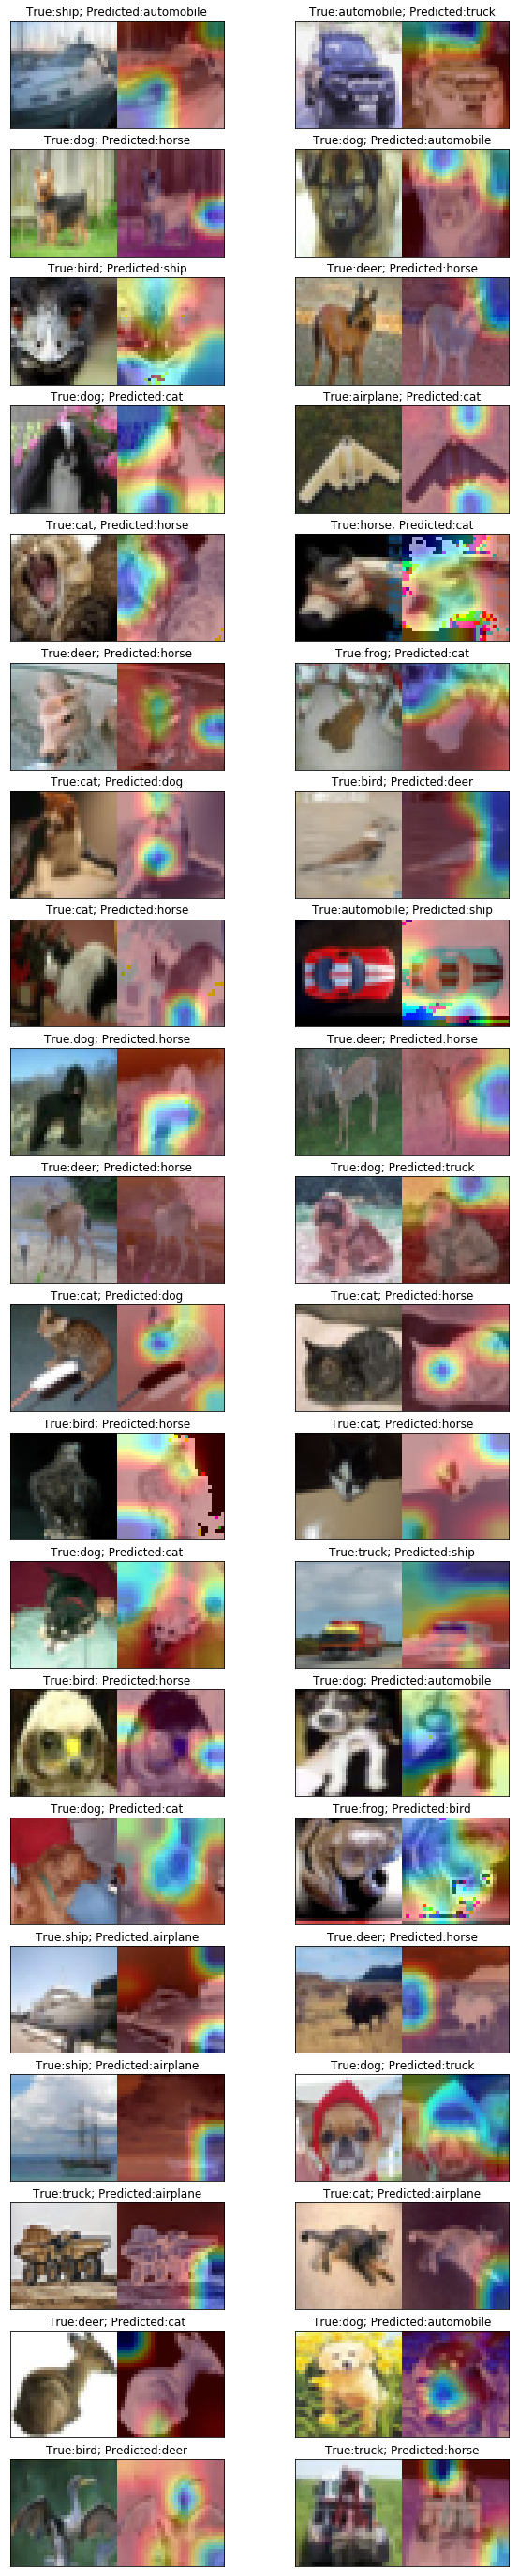

In [0]:
fig = plt.figure(figsize=(10,50))

for i,j in enumerate(misclassified[:40]):
  im = whatchyalookingat(j[0])  
  ax = fig.add_subplot(20, 2, i+1, xticks=[], yticks=[]) 
  ax.set_title(f'True:{class_names[true_class[j[0]]]}; Predicted:{class_names[j[1]]}')
  plt.imshow(im)
#   print(i,j[0],class_names[j[1]],class_names[true_class[j[0]]])
  
plt.show()

# Using a self Trained architecture

The model above was giving very bad gradCam output because we had to use initial layers, as last block layers of resnet18 are either 1x1 or 2x2.

Here I have used a custom trained model with final layer being 8x8, enough to give us good gradCAM.

In [0]:
from keras.models import load_model
# load model back
model = load_model('/content/gdrive/My Drive/EIP3/Session5/Assignment5_self.h5')

W0701 23:05:01.622199 140443306850176 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
#Predicting on test data
predict = model.predict(test_features)

In [0]:
#getting misclassified images
true_class = np.argmax(test_labels, axis = -1)
pred_classes = np.argmax(predict, axis = -1)
misclassified = [(i,x) for i, x in enumerate(pred_classes) if pred_classes[i]!=true_class[i]]

In [0]:
def whatchyalookingat(j):
  img = test_features[j]
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("c_final")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(last_conv_layer.output_shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
#   img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255 * img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img*255, 0.6, heatmap, 0.4, 0)

  concatimg = cv2.hconcat([img,superimposed_img])
  
  return(concatimg)

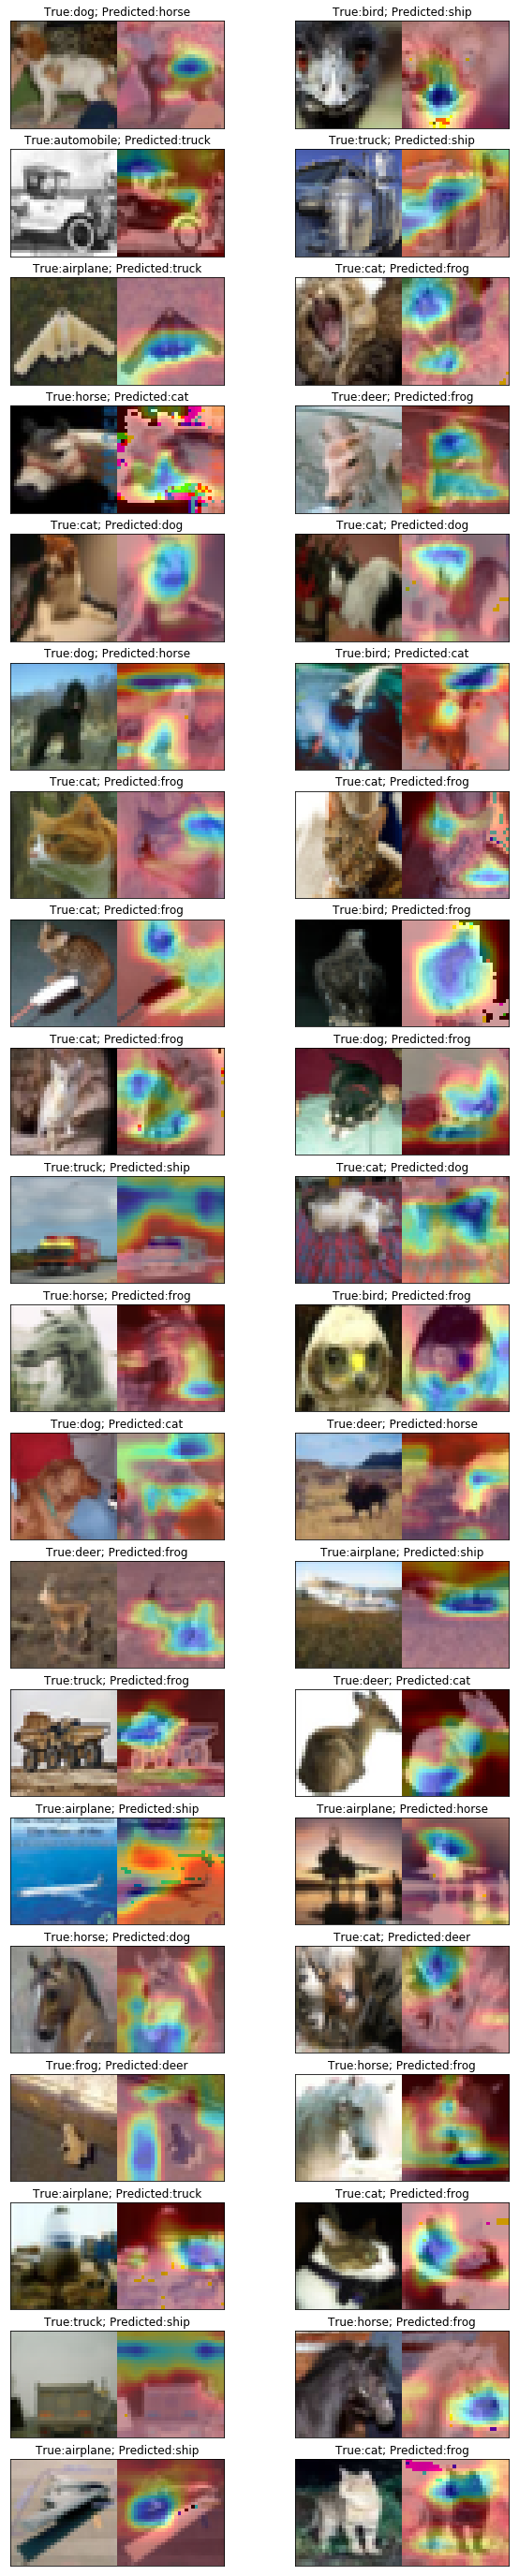

In [0]:
fig = plt.figure(figsize=(10,50))

for i,j in enumerate(misclassified[:40]):
  im = whatchyalookingat(j[0])  
  ax = fig.add_subplot(20, 2, i+1, xticks=[], yticks=[]) 
  ax.set_title(f'True:{class_names[true_class[j[0]]]}; Predicted:{class_names[j[1]]}')
  plt.imshow(im)
#   print(i,j[0],class_names[j[1]],class_names[true_class[j[0]]])
  
plt.show()